In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [2]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [3]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                
                # Get the top predicted class
                top_p, top_class = ps.topk(1, dim=1)
                
                # Check whether predicted class matches with true class
                equals = top_class == labels.view(*top_class.shape)
                
                # Calculate accuracy
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # Enable training mode again
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.607..  Test Loss: 0.477..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.488..  Test Loss: 0.456..  Test Accuracy: 0.837
Epoch: 3/30..  Training Loss: 0.451..  Test Loss: 0.418..  Test Accuracy: 0.847
Epoch: 4/30..  Training Loss: 0.433..  Test Loss: 0.432..  Test Accuracy: 0.846
Epoch: 5/30..  Training Loss: 0.424..  Test Loss: 0.407..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.411..  Test Loss: 0.385..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.403..  Test Loss: 0.390..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.397..  Test Loss: 0.437..  Test Accuracy: 0.845
Epoch: 9/30..  Training Loss: 0.395..  Test Loss: 0.394..  Test Accuracy: 0.864
Epoch: 10/30..  Training Loss: 0.383..  Test Loss: 0.406..  Test Accuracy: 0.859
Epoch: 11/30..  Training Loss: 0.388..  Test Loss: 0.392..  Test Accuracy: 0.863
Epoch: 12/30..  Training Loss: 0.375..  Test Loss: 0.378..  Test Accuracy: 0.869
Epoch: 13/30..  Training Loss: 0.369.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

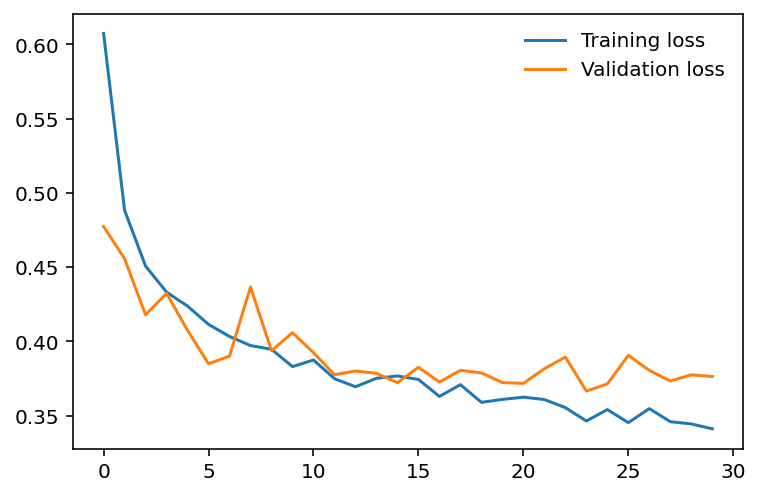

In [5]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

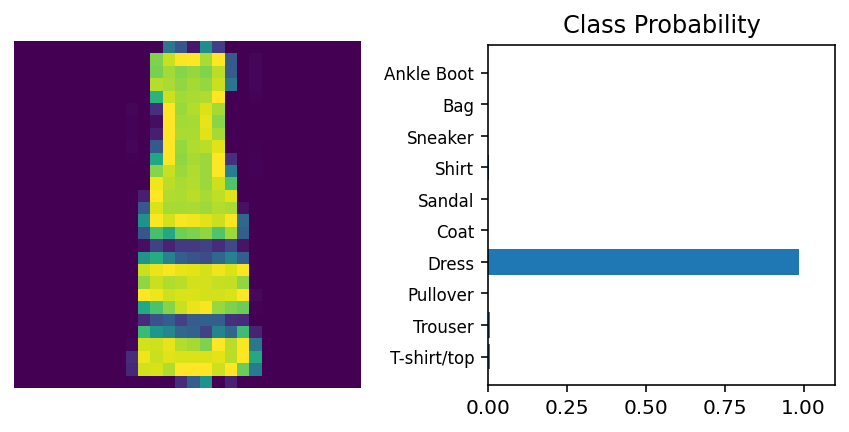

In [6]:
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Saving a PyTorch model

In [8]:
print("The model architecture: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

The model architecture: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [9]:
# Build a dictionary with all the information you need to compeletely rebuild the model.

checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [model.fc1.out_features, model.fc2.out_features,model.fc3.out_features,model.fc4.out_features],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Loading a PyTorch model

In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Classifier()
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [14]:
model = load_checkpoint('checkpoint.pth')
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
